# Networks (Advanced) Tutorial

In [1]:
import sys
import os
import time
# Add the path to the parent module
sys.path.append(os.path.abspath('../..'))

In [2]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

from deeppy import LearnFrame, DataGetter, Network, Model



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Data

#### MNIST Classification

In this tutorial we want to show how to create more complex networks. We want to create a CNN network and 2 Linear layers.

Let's classify MNIST dataset

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor
training_data = datasets.MNIST(
    root="datasets",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="datasets",
    train=False,
    download=True,
    transform=ToTensor()
)

X,X_test = training_data.train_data.unsqueeze(1) / 255, test_data.train_data.unsqueeze(1) / 255
y, y_test = training_data.train_labels, test_data.train_labels
batch_size = 128
data = DataGetter(X=X,y=y,X_test = X_test, y_test= y_test, batch_size = batch_size)

data_set_epochs = len(X) / batch_size

/home/boz/anaconda3/envs/deeppy/lib/python3.13/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/boz/anaconda3/envs/deeppy/lib/python3.13/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


# Model

#### CNN 

Let's create 2 layer CNN network with Relu activation. We want to have 

[1 -> 32]

[32 -> 64]

channels



In [4]:
cnn = {
            "layers":[1,32,64],
            "blocks":[nn.Conv2d, nn.ReLU,],
            "block_args": [{"kernel_size" : 3, "stride":1, "padding"  : 1} , {} ],
            "out_act":nn.ReLU,
            "weight_init":"uniform",
}

#### MaxPool and Dropout after CNN

We also want to add a MaxPool and Dropout layers after the CNN architecture.



In [5]:
pool_drouput = {
    "blocks" : [nn.MaxPool2d, nn.Dropout],
    "block_args" : [{"kernel_size":2}, {"p":0.25}]
}

#### Dense layer bridge

Since after the CNN, we want to use a dense layer we need to flatten our image. You can use nn.Flatten easily, however we want to show you how you can write your own layers

See: https://pytorch.org/docs/stable/notes/extending.html

In [6]:

class Flatten(nn.Module):
    def __init__(self, start_dim: int = 1, end_dim: int = -1) -> None:
        super().__init__()
        self.start_dim = start_dim
        self.end_dim = end_dim

    def forward(self, input):
        return input.flatten(self.start_dim, self.end_dim)

flatten = {
    "blocks" : [Flatten]
}

#### Dense Layer

In [7]:
dense = {
    "layers":[64*14*14, 128, 10],
    "blocks":[nn.Linear, nn.ReLU],
    "block_args":[],
    "out_act":nn.Identity,
    "weight_init":"uniform",
}


#### Network

In [8]:
network_params = [cnn, pool_drouput, flatten, dense]


Scheduler_params = {
    "scheduler" : optim.lr_scheduler.StepLR,
    "gamma":0.1**(1/1000),
    "auto_step":False,
    "step_size" : 1
}
Optimizer_params = {
    "optimizer":optim.AdamW,
    "optimizer_args":{"lr" : 1e-3, "amsgrad" : True},
    "clipper":torch.nn.utils.clip_grad_value_,
    "clipper_params":{"clip_value" : 100},
    "scheduler_params":Scheduler_params,
}

network_params = {
    "arch_params" : network_params,  
    "task" :"reg",
    "optimizer_params" : Optimizer_params
}

net = Network(**network_params)
print(net)
print("----------")
X,y = data.train_data()
print(X.shape)

print(f"out shpae : {net(X).shape}")

Network(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Flatten()
    (7): Linear(in_features=12544, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=10, bias=True)
    (10): Identity()
  )
)
----------
torch.Size([128, 1, 28, 28])
out shpae : torch.Size([128, 10])


In [9]:
model_params = {
    "network_params" : network_params,
    "device" : device,
    "criterion" : nn.CrossEntropyLoss()
}


model = Model(**model_params)
#net = Network(**network_params)
#print(net)
#print("----------")
#print(f"out shpae : {net(data.train_data()).shape}")

#model = B_Vae.load("checkpoint/b_vae.pt")

### Alternative to Flatten Layer (Advanced)

Rewrite the forward function

Remember that we have fed 3 architectures: CNN, Pool/dropout and Flatten. We can use partial_forward function to call each module seperately

In [10]:

def new_forward(self,X):
    #Cnn Layer
    X = self.partial_forward(X,0)
    #Pool layer
    X = self.partial_forward(X,1)
    
    #Flatten layer
    return X.flatten(start_dim=1)

import types
model.net.forward  = types.MethodType(new_forward, model.net)


# Create LearnFrame

In [11]:
lf = LearnFrame(model, data)

In [12]:
lf.metric.plot_lr = True

<Figure size 640x480 with 0 Axes>

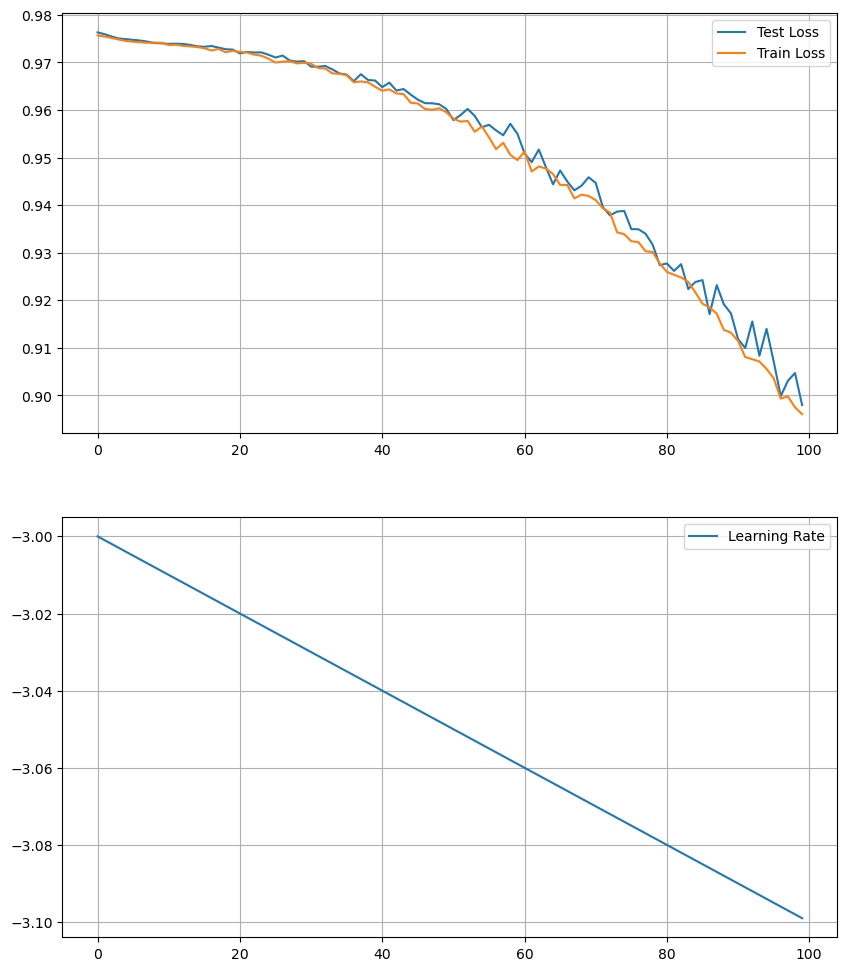

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [13]:
for i in range(100):
    lf.optimize()
    lf.test()
    
    lf.scheduler_step()
        
    if i % 5 ==0:
        lf.plot(log=True,show_result= False)

lf.plot(log=True,show_result= True)

/tmp/ipykernel_36126/3585804264.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = nn.functional.softmax(lf.model.predict(im)[0]).argmax().item()


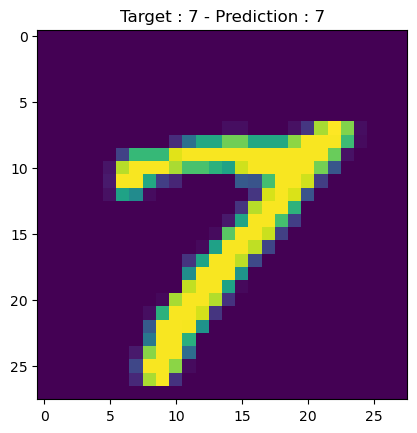

In [39]:
im, l = data.train_data()

with torch.no_grad():
    pred = nn.functional.softmax(lf.model.predict(im)[0]).argmax().item()

plt.imshow(im[0,0])
plt.title(f"Target : {l[0]} - Prediction : {pred}")
plt.show()

